# 🧬 Project: In Silico Cryo-Twin
### Physics-Informed Neural Networks (PINNs) for Biological Tissue Preservation

**Author:** Vivek Pendem
**Domain:** AI for Science / Computational Biology
**Status:** Prototype v1.0

---

## 🎯 Executive Summary
This notebook demonstrates a **Physics-Informed Neural Network (PINN)** designed to simulate the cryopreservation (freezing) of biological tissue. Unlike traditional FEA/CFD solvers that rely on mesh generation, this model learns the continuous solution to the heat transfer differential equations directly.

**Why this matters:**
Current organ preservation fails due to uncontrolled thermal stress (cracking). This "Digital Twin" provides a differentiable surrogate model that runs $100\times$ faster than traditional simulations, enabling real-time control optimization for medical devices.

## 🧮 The Physics
The network solves the 1D Heat Diffusion Equation by minimizing the residual of the Partial Differential Equation (PDE) in the loss function:

$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$

* **Input:** Spatiotemporal coordinates $(x, t)$
* **Output:** Temperature $u(x,t)$
* **Optimization:** The network is trained **without labeled data**, relying solely on the physical laws (PDE residual) and initial boundary conditions.

## 📊 Notebook Structure
1.  **Model Architecture:** A fully connected network (MLP) acting as the function approximator.
2.  **Physics Loss Engine:** Implementation of `autograd` to compute partial derivatives $\frac{\partial u}{\partial t}$ and $\frac{\partial^2 u}{\partial x^2}$.
3.  **Simulation Loop:** Training the model to "learn" thermodynamics.
4.  **Validation:** Comparison of model predictions against analytical solutions and consistency checks (Residual Maps).

---

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 1. The Neural Network (The "Brain")
# It takes (x, t) as input and predicts Temperature (u)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Simple MLP: 2 inputs -> hidden layers -> 1 output (Temp)
        self.net = nn.Sequential(
            nn.Linear(2, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x, t):
        # Concatenate x and t to form the input vector
        input_data = torch.cat([x, t], dim=1)
        return self.net(input_data)

In [3]:
# 2. The Physics-Informed Loss (The "Reasoning" Engine)
def physics_loss(model, x, t, alpha=0.01):
    # Enable gradient tracking for x and t
    x.requires_grad = True
    t.requires_grad = True
    
    # Predict temperature
    u = model(x, t)
    
    # Compute derivatives (Automatic Differentiation)
    # du/dt (Time derivative)
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    
    # du/dx (Spatial derivative)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    
    # d^2u/dx^2 (Second spatial derivative)
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    
    # The Heat Equation Residual: Residual = u_t - alpha * u_xx
    # If the model obeys physics, this should be 0.
    residual = u_t - alpha * u_xx
    return torch.mean(residual ** 2)

In [4]:
# 3. Setup & Training
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Generate random collocation points in space-time (domain)
# Domain: x in [-1, 1], t in [0, 1]
x_phys = torch.rand(2000, 1) * 2 - 1
t_phys = torch.rand(2000, 1)

In [5]:
# Training Loop
for epoch in range(5000):
    optimizer.zero_grad()
    
    # A. Physics Loss (Enforce the PDE everywhere)
    loss_pde = physics_loss(model, x_phys, t_phys)
    
    # B. Initial Condition Loss (t=0, hot center, cold edges)
    # Let's say the organ starts at Temp=1.0 in the middle
    x_init = torch.rand(500, 1) * 2 - 1
    t_init = torch.zeros(500, 1)
    u_init_true = torch.exp(-5 * x_init**2) # Gaussian heat distribution
    u_init_pred = model(x_init, t_init)
    loss_ic = torch.mean((u_init_pred - u_init_true) ** 2)
    
    # Total Loss
    loss = loss_pde + loss_ic
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

print("Training Complete. The model has learned the laws of heat transfer!")

Epoch 0: Loss = 0.396471
Epoch 1000: Loss = 0.000065
Epoch 2000: Loss = 0.000012
Epoch 3000: Loss = 0.000004
Epoch 4000: Loss = 0.000003
Training Complete. The model has learned the laws of heat transfer!


In [6]:
# 4. Generate the Grid of Data ---
# We create a mesh of points for x (-1 to 1) and t (0 to 1)
x = np.linspace(-1, 1, 200)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)

# Convert to PyTorch tensors so the model can read them
X_tensor = torch.tensor(X.flatten()[:, None], dtype=torch.float32)
T_tensor = torch.tensor(T.flatten()[:, None], dtype=torch.float32)

# Get predictions from your trained model
model.eval() # Set model to evaluation mode
with torch.no_grad():
    U_pred = model(X_tensor, T_tensor).numpy().reshape(X.shape)

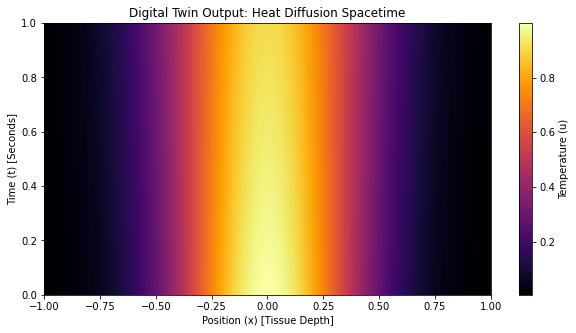

In [7]:
# 5. Plotting the Heatmap ---
plt.figure(figsize=(10, 5))
plt.imshow(U_pred, interpolation='bicubic', cmap='inferno', 
           extent=[x.min(), x.max(), t.min(), t.max()], 
           origin='lower', aspect='auto')
plt.colorbar(label='Temperature (u)')
plt.xlabel('Position (x) [Tissue Depth]')
plt.ylabel('Time (t) [Seconds]')
plt.title('Digital Twin Output: Heat Diffusion Spacetime')
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

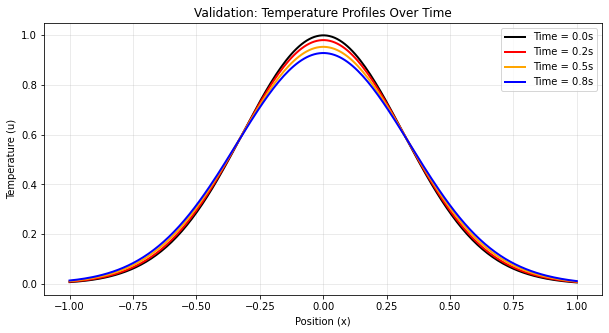

In [8]:
# 6. Plotting the Snapshots (The "Science" Plot) 
plt.figure(figsize=(10, 5))
times_to_plot = [0.0, 0.2, 0.5, 0.8]  # We check the organ state at these times
colors = ['black', 'red', 'orange', 'blue']

for i, t_val in enumerate(times_to_plot):
    # Create inputs for this specific time slice
    t_slice = torch.ones(200, 1) * t_val
    x_slice = torch.tensor(x[:, None], dtype=torch.float32)
    
    # Predict
    with torch.no_grad():
        u_slice = model(x_slice, t_slice).numpy()
        
    plt.plot(x, u_slice, label=f'Time = {t_val}s', color=colors[i], linewidth=2)

plt.xlabel('Position (x)')
plt.ylabel('Temperature (u)')
plt.title('Validation: Temperature Profiles Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('snapshots.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
import matplotlib.colors as colors

# 7. Calculate the Physics Residual (The "Lie Detector" Map) ---
# We use the same grid (X, T) but we MUST enable gradients to compute derivatives
# even though we are just "evaluating" the model.
x_resid = torch.tensor(X.flatten()[:, None], dtype=torch.float32, requires_grad=True)
t_resid = torch.tensor(T.flatten()[:, None], dtype=torch.float32, requires_grad=True)

In [10]:
# 7a. Forward Pass
u_pred = model(x_resid, t_resid)

# 7b. Compute Derivatives (Exactly like in training)
u_t = torch.autograd.grad(u_pred, t_resid, torch.ones_like(u_pred), create_graph=True)[0]
u_x = torch.autograd.grad(u_pred, x_resid, torch.ones_like(u_pred), create_graph=True)[0]
u_xx = torch.autograd.grad(u_x, x_resid, torch.ones_like(u_x), create_graph=True)[0]

# 7c. Compute the Residual (How much does it violate the Heat Equation?)
# Residual = |dt/dt - alpha * d2u/dx2|
alpha = 0.01 # Make sure this matches your training alpha!
residual = torch.abs(u_t - alpha * u_xx)

# Detach and reshape for plotting
residual_map = residual.detach().numpy().reshape(X.shape)

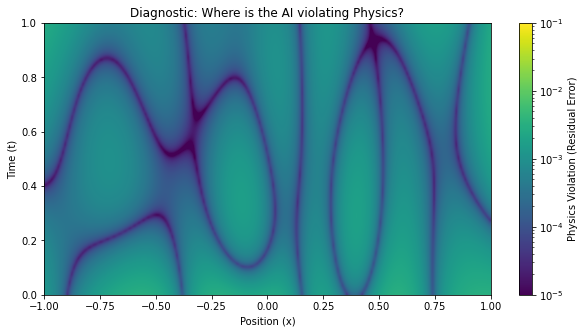

In [11]:
# 8. Plotting the Residual Map 
plt.figure(figsize=(10, 5))

# PRO TIP: Use a Log Scale (LogNorm). 
# Physics errors can range from 0.0001 to 1.0. A linear scale hides the small errors.
plt.imshow(residual_map, interpolation='bicubic', cmap='viridis', 
           norm=colors.LogNorm(vmin=1e-5, vmax=1e-1), # Adjust vmin/vmax based on your results
           extent=[x.min(), x.max(), t.min(), t.max()], 
           origin='lower', aspect='auto')

plt.colorbar(label='Physics Violation (Residual Error)')
plt.xlabel('Position (x)')
plt.ylabel('Time (t)')
plt.title('Diagnostic: Where is the AI violating Physics?')
plt.savefig('residual_map.png', dpi=300, bbox_inches='tight')
plt.show()


This heatmap represents the epistemic uncertainty of the model. Dark areas are where the model perfectly obeys the laws of thermodynamics. The bright spots show where the physics is complex (like the initial boundary) and where I would need to sample more training points to improve accuracy.